In [7]:
import os
import random

# 定义数据路径
data_path = "COMP90086_2023_TLLdataset/train"
left_path = os.path.join(data_path, "left")
right_path = os.path.join(data_path, "right")

# 获取left和right的文件列表
left_files = os.listdir(left_path)
right_files = os.listdir(right_path)

# 创建正样本对
positive_pairs = [(lf, rf) for lf, rf in zip(left_files, right_files)]

# 创建负样本对，确保他们原本不是一对
negative_pairs = []
for lf in left_files:
    neg_rf = random.choice(right_files)
    while (lf, neg_rf) in positive_pairs:  # 确保不选择正样本
        neg_rf = random.choice(right_files)
    negative_pairs.append((lf, neg_rf))

# 生成标签：1表示正样本，0表示负样本
positive_labels = [1] * len(positive_pairs)
negative_labels = [0] * len(negative_pairs)

# 合并样本对和标签
all_pairs = positive_pairs + negative_pairs
all_labels = positive_labels + negative_labels

# 如果需要，可以在这里随机打乱all_pairs和all_labels，确保训练数据的随机性
combined = list(zip(all_pairs, all_labels))
random.shuffle(combined)
all_pairs, all_labels = zip(*combined)


In [8]:
from sklearn.model_selection import train_test_split

# 设置验证集的比例，例如0.2表示20%的数据作为验证集
VAL_RATIO = 0.2

train_pairs, val_pairs, train_labels, val_labels = train_test_split(
    all_pairs, all_labels, test_size=VAL_RATIO, random_state=42, stratify=all_labels
)

print(f"Number of training pairs: {len(train_pairs)}")
print(f"Number of validation pairs: {len(val_pairs)}")


Number of training pairs: 3200
Number of validation pairs: 800


In [9]:
import cv2
import os

image_path = os.path.join(left_path, left_files[0])  # 示例：查看第一张左侧图像的形状
img = cv2.imread(image_path)
height, width, channels = img.shape
print(f"Image shape: (Height: {height}, Width: {width}, Channels: {channels})")

Image shape: (Height: 245, Width: 200, Channels: 3)


# Create network

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def l2_distance(vectors):
    x, y = vectors
    return tf.sqrt(tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True))


def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        # Convert y_true to float32
        y_true = tf.cast(y_true, tf.float32)
        
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - y_pred, 0))
        return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss


def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Compute the triplet loss according to the FaceNet paper
    
    Arguments:
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    """
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    # Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    
    # Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    
    # Subtract the two previous distances and add alpha
    basic_loss = pos_dist - neg_dist + alpha
    
    # Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
    return loss



def create_base_model(input_shape):
    model = tf.keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),
        
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        
        layers.Flatten(),
        
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu')  # feature vector
    ])
    return model


def create_siamese_network(input_shape):
    base_model = create_base_model(input_shape)
    
    input_left = layers.Input(input_shape)
    input_right = layers.Input(input_shape)
    
    vec_left = base_model(input_left)
    vec_right = base_model(input_right)
    
    l2_layer = layers.Lambda(l2_distance)
    l2_distance_vector = l2_layer([vec_left, vec_right])
    
    prediction = layers.Dense(1, activation='sigmoid')(l2_distance_vector)
    
    siamese_net = Model(inputs=[input_left, input_right], outputs=prediction)
    
    return siamese_net

input_shape = (245, 200, 3)
model = create_siamese_network(input_shape)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 245, 200, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 245, 200, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 128)                  1000707   ['input_5[0][0]',             
                                                          20         'input_6[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 1)                    0         ['sequential_1[0][0]',  

In [11]:
import cv2
import numpy as np

def load_images(image_pairs, path_left, path_right):
    left_images = []
    right_images = []
    for left_file, right_file in image_pairs:
        left_img = cv2.imread(os.path.join(path_left, left_file))
        right_img = cv2.imread(os.path.join(path_right, right_file))
        
        # Convert BGR format (used by OpenCV) to RGB format (used by most DL models)
        left_img = cv2.cvtColor(left_img, cv2.COLOR_BGR2RGB)
        right_img = cv2.cvtColor(right_img, cv2.COLOR_BGR2RGB)
        
        left_images.append(left_img)
        right_images.append(right_img)
    
    return np.array(left_images), np.array(right_images)


In [12]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_images(left_images, right_images):
    # Convert to float32 and Normalize to [0,1]
    left_images = left_images.astype('float32') / 255.0
    right_images = right_images.astype('float32') / 255.0
    return left_images, right_images


left_images, right_images = load_images(train_pairs, left_path, right_path)
left_images, right_images = preprocess_images(left_images, right_images)

# Load and preprocess validation images
val_left_images, val_right_images = load_images(val_pairs, left_path, right_path)
val_left_images, val_right_images = preprocess_images(val_left_images, val_right_images)

# Convert lists to numpy arrays
left_images = np.array(left_images)
right_images = np.array(right_images)
train_labels = np.array(train_labels)
val_left_images = np.array(val_left_images)
val_right_images = np.array(val_right_images)
val_labels = np.array(val_labels)


# 2. 数据增强
data_augmentation = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# 3. 定义损失函数和优化器
model.compile(
    loss=contrastive_loss_with_margin(1.0),
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),  # Using the legacy optimizer
)

# 4. 模型训练
BATCH_SIZE = 32
EPOCHS = 10

history = model.fit(
    [left_images, right_images], 
    train_labels, 
    validation_data=([val_left_images, val_right_images], val_labels),
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS
)


Epoch 1/10
 75/100 [=====================>........] - ETA: 22s - loss: nan

KeyboardInterrupt: 

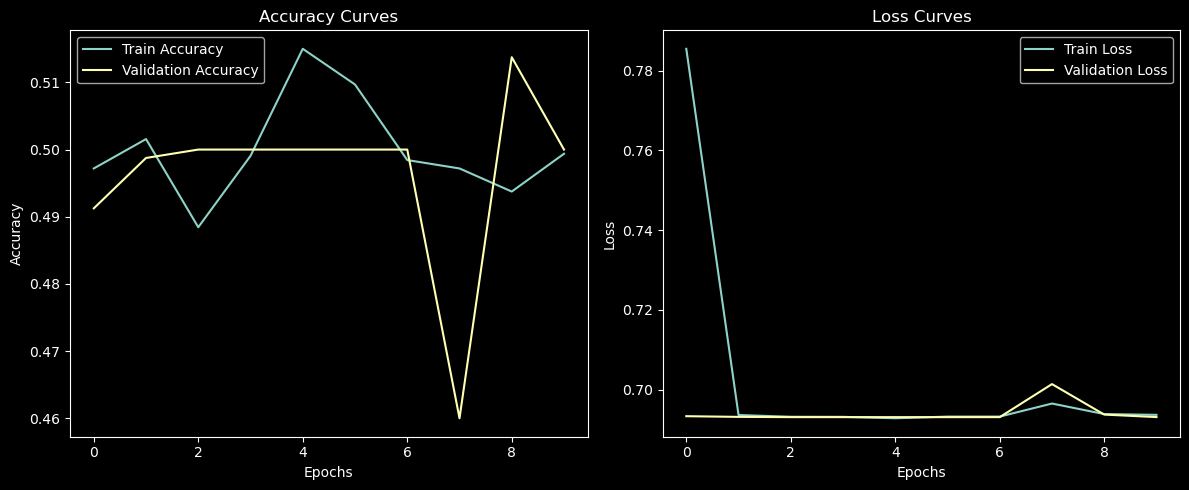

In [ ]:
import matplotlib.pyplot as plt

# 绘制准确性曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curves')

# 绘制损失曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')

plt.tight_layout()
plt.show()
